## CSCS530 Winter 2015
#### Complex Systems 530 - Computer Modeling of Complex Systems (Winter 2015)

  * Course ID: CMPLXSYS 530
  * Course Title: Computer Modeling of Complex Systems
  * Term: Winter 2015
  * Schedule: Wednesdays and Friday, 1:00-2:30PM ET
  * Location: 120 West Hall (http://www.lsa.umich.edu/cscs/research/computerlab)
  * Teachers: [Mike Bommarito](https://www.linkedin.com/in/bommarito) and [Sarah Cherng](https://www.linkedin.com/pub/sarah-cherng/35/1b7/316)

#### [View this repository on NBViewer](http://nbviewer.ipython.org/github/mjbommar/cscs-530-w2015/tree/master/)


# Monte Carlo simulations

  Monte Carlo methods and simulations are philosophically related to and often incorporated into agent-based models.  In the words of [Wiki](http://en.wikipedia.org/wiki/Monte_Carlo_method#Definitions):
  > Sawilowsky[9] distinguishes between a simulation, a Monte Carlo method, and a Monte Carlo simulation: a simulation is a 
  > fictitious representation of reality, a Monte Carlo method is a technique that can be used to solve a mathematical or
  > statistical problem, and a Monte Carlo simulation uses repeated sampling to determine the properties of some phenomenon (or
  > behavior). Examples:
  > * **Simulation:** Drawing one pseudo-random uniform variable from the interval [0,1] can be used to simulate the tossing of a coin: If the value is less than or equal to 0.50 designate the outcome as heads, but if the value is greater than 0.50 designate the outcome as tails. This is a simulation, but not a Monte Carlo simulation.
  
  > * **Monte Carlo method:** Pouring out a box of coins on a table, and then computing the ratio of coins that land heads versus tails is a Monte Carlo method of determining the behavior of repeated coin tosses, but it is not a simulation.
  
  > * **Monte Carlo simulation:** Drawing a large number of pseudo-random uniform variables from the interval [0,1], and assigning values less than or equal to 0.50 as heads and greater than 0.50 as tails, is a Monte Carlo simulation of the behavior of repeatedly tossing a coin.
  
In order conduct Monte Carlo simulations (the theory was developed a long time ago), we needed to develop two things:

* A computer (a system that can automate instructions) capable of conducting millions of simulations (random draws); and
* A source of good random numbers.

## First hitting time simulations

  One classic problem in ecology and finance is __hitting time__, __stopping time__, or __passage time__ problem.  In [the first hitting time](http://en.wikipedia.org/wiki/First-hitting-time_model) problem, one models the state of some variable over time until it hits a certain condition, at which point the process stops.   
  
  For example, one might model the level of some renewable resource like a forest or fishery.  So long as the resource level is greater than zero, the resource can continue to regenerate; however, if at any point the "last" unit of the resource is extracted, then the resource dies.  Thus, we might simulate the survival of our resource under certain dynamics of growth or extraction.  Let's walk few examples below.


## Uniform arithmetic growth and extraction

  In our first example, let's start by simulating a single forest under the following assumptions:

  * The forest starts with ``initial_resource`` units of forest.
  * Each turn, we sample a continuous random value in ``[min_consumption, max_consumption)`` for extraction.  We decrease the forest by subtracting this amount.
  * Each turn, we also sample a continuous random value in ``[min_growth, max_growth)`` for growth.  We increase the forest by adding this amount.

In [1]:
# Imports
import numpy
import matplotlib.pyplot as plt
import pandas

# Display matplotlib figs inline
%matplotlib inline
#import seaborn; seaborn.set()

# Import widget methods
from ipywidgets import *

In [2]:
# Set model parameters
initial_resource = 2 # Units of forest
min_consumption = 2
max_consumption = 3
min_growth = 2 # Initially, match extraction rates
max_growth = 3
max_steps = 100000

# Set model state variables
current_resource = initial_resource
resource_history = [current_resource]
growth_history = []
consumption_history = []

# Continue running until the resource hits at or below zero
while current_resource > 0:
    # Sample growth
    growth = numpy.random.uniform(min_growth, max_growth)
    
    # Sample consumption
    consumption = numpy.random.uniform(min_consumption, max_consumption)
    
    # Change forest resource level
    current_resource += growth - consumption
    
    # Keep track of history
    resource_history.append(current_resource)
    growth_history.append(growth)
    consumption_history.append(consumption)
    
    # Break at max steps
    if len(resource_history) > max_steps:
        break

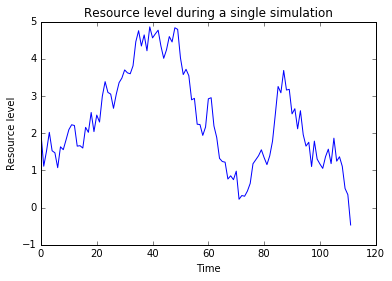

In [3]:
# Plot the time series for each component
f = plt.figure()
plt.plot(resource_history)
plt.xlabel('Time')
plt.ylabel('Resource level')
plt.title('Resource level during a single simulation')

What conclusions can we draw from this graph? None. We shouldn't draw any conclusions from a single simulation (n=1).

Note the boundary conditions here. We have an infinite upper boundary (forest can grow to any size) but by moving only a small distance we hit a finite, terminal lower boundary (forest is gone forever once it goes to zero).

## Interactive simulation

  Let's practice wrapping our simulation in a method so that we can create an interactive applet.

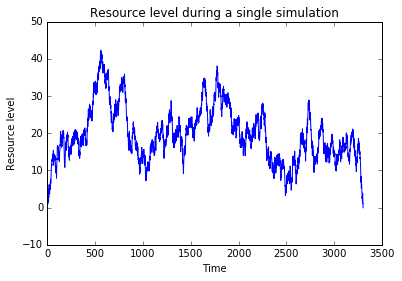

In [13]:
def run_simulation(initial_resource = 2, min_consumption = 2, max_consumption = 3,
                   min_growth = 2, max_growth = 3, max_steps=100000):
    """
    Simulate a resource under uniform arithmetic growth and consumption.
    """

    # Set model state variables
    current_resource = initial_resource
    resource_history = [current_resource]
    growth_history = []
    consumption_history = []

    # Continue running until the resource hits at or below zero
    while current_resource > 0:
        # Sample growth
        growth = numpy.random.uniform(min_growth, max_growth)

        # Sample consumption
        consumption = numpy.random.uniform(min_consumption, max_consumption)

        # Change forest resource level
        current_resource += growth - consumption

        # Keep track of history
        resource_history.append(current_resource)
        growth_history.append(growth)
        consumption_history.append(consumption)
        
        # Break at max steps
        if len(resource_history) > max_steps:
            break
    
    # Plot the time series for each component
    f = plt.figure()
    plt.plot(resource_history)
    plt.xlabel('Time')
    plt.ylabel('Resource level')
    plt.title('Resource level during a single simulation')

# Call the ipython interact() method to allow us to explore the parameters and sampling
interact(run_simulation, initial_resource=(1, 1000),
         min_consumption = (0, 20),
         max_consumption = (0, 20),
         min_growth = (0, 20),
         max_growth = (0, 20))

## Monte Carlo simulation

  As you adjust the sliders in the applet above, you will likely see very different simulation outcomes.  In some cases, the forest may die off quickly; in others, it may survive so long as to cause your computer to halt the simulation!  
  
  The important idea to understand here is that each simulation is just that - __a single simulation__.  Regardless of what might happen in a single simulation, we can not make general claims about our system from a single simulation.  Our goal is to understand the behavior of our system through the distribution of many simulations.  So instead of looking at a single simulation and basing our hitting time on this simulation, we should instead generate many simulations and look at their distribution over time.
  
  Let's do this below by improving our single simulation method to return the resource time series.  Then, we can wrap this method in another method that will generate many forest simulations for analysis.

In [19]:
def run_simulation(initial_resource=1, min_consumption=0.1, max_consumption=0.2, 
                   min_growth=0.1, max_growth=0.2, max_steps=100000):
    """
    Simulate a resource under uniform arithmetic growth and consumption.
    """

    # Set model state variables
    current_resource = initial_resource
    resource_history = [current_resource]
    growth_history = []
    consumption_history = []

    # Continue running until the resource hits at or below zero
    while current_resource > 0:
        # Sample growth
        growth = numpy.random.uniform(min_growth, max_growth)

        # Sample consumption
        consumption = numpy.random.uniform(min_consumption, max_consumption)

        # Change forest resource level
        current_resource += growth - consumption

        # Keep track of history
        resource_history.append(current_resource)
        growth_history.append(growth)
        consumption_history.append(consumption)
        
        # Break at max steps
        if len(resource_history) > max_steps:
            break
    
    # Plot the time series for each component
    return resource_history

def run_monte_carlo(initial_resource=1, min_consumption=0.1, max_consumption=0.2, 
                   min_growth=0.1, max_growth=0.2, max_steps=100000, num_samples = 100):
    """
    Run many individual simulations and output a summary of the Monte Carlo experiment.
    """
    # Sample data
    sample_results = []
    
    # Run simulations
    for sample_id in range(num_samples):
        sample_results.append(run_simulation(initial_resource, min_consumption, max_consumption,
                                             min_growth, max_growth, max_steps))
        
    return pandas.DataFrame(sample_results).T

def plot_monte_carlo_runs(initial_resource=1, min_consumption=0.1, max_consumption=0.2, 
                   min_growth=0.1, max_growth=0.2, max_steps=100000, num_samples = 100):
    # Get data and plot
    simulation_data = run_monte_carlo(initial_resource, min_consumption, max_consumption,
                    min_growth, max_growth, max_steps, num_samples)
    f = plt.figure(figsize=(5,4))
    simulation_data.plot(legend=False, alpha=0.5, linewidth=0.5, linestyle='-', 
                         colormap='Blues')
    return simulation_data

### Simulation Trajectories

  In the plot below, we plot the result of all Monte Carlo simulationt trajectories.  You can see that many trajectories flatline at the $y=0$ axis, but that some do end up making it to our terminal condition ($t=100000$).

CPU times: user 6.64 s, sys: 143 ms, total: 6.79 s
Wall time: 6.76 s


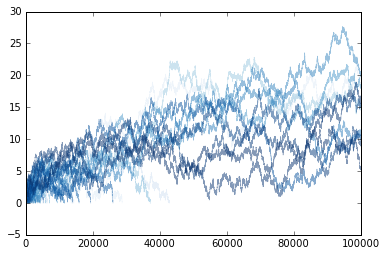

In [24]:
%%time

# Plot one set of 1000 simulations
simulation_data = plot_monte_carlo_runs(initial_resource=1, min_consumption=0.1, max_consumption=0.2,
                                        min_growth=0.1, max_growth=0.2, num_samples=100)

### Average Trajectory
  
  Instead of trying to make sense of all 1000 samples by plotting them simultaneously,  we might instead plot the __average__ resource level at a fixed time $t$.  Additionally, we might augment this average with a view of the standard deviation or fixed percentile.  In the examples below, we'll show both options.

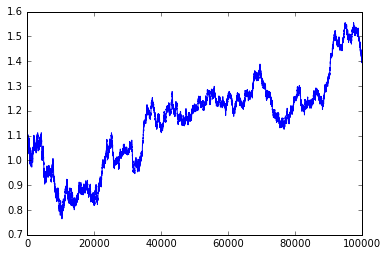

In [25]:
# Plot the average line
f = plt.figure()
average_ts = simulation_data.fillna(0).mean(axis=1)
average_ts.plot()

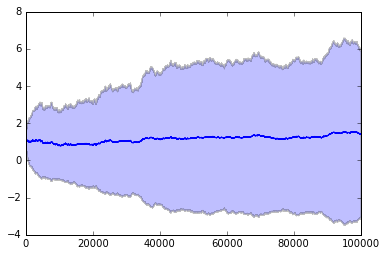

In [26]:
# Plot the average line
f = plt.figure()
average_ts = simulation_data.fillna(0).mean(axis=1)
average_ts.plot()

# Overplot the +/- standard deviation bounds
# N.B.: We can vary the treatment of "dead" sims using 
# the .std(skipna=True/False) argument.
standard_deviation_ts = simulation_data.fillna(0).std(axis=1)
lower_bound_ts = average_ts - standard_deviation_ts
upper_bound_ts = average_ts + standard_deviation_ts
plt.fill_between(average_ts.index, lower_bound_ts, upper_bound_ts,
                 alpha=0.25)


#### Lower bound

  In this case, the lower bound definition using $\mu - \sigma$ results in a cone of trajectories that doesn't make sense.  Another approach would be to use a non-parametric characterization of the data, for example, by the plotting the lower quartile, median, and upper quartile.

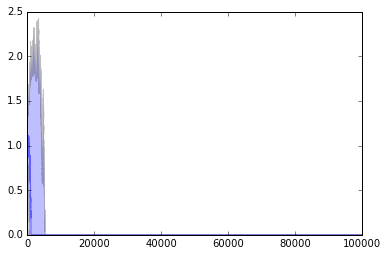

In [27]:
# Get the 10th, median, and 90th percentiles
bound_ts = simulation_data.fillna(0).quantile([0.25, 0.5, 0.75], axis=1).T
bound_ts.columns = ['lower', 'median', 'upper']
plt.plot(bound_ts.index, bound_ts['median'], alpha=0.5)
plt.fill_between(bound_ts.index, bound_ts['lower'], bound_ts['upper'],
                 alpha=0.25)

#### Right bound
  
  As you can see, much of our figure is wasted on "dead" space on the right bound.  Let's subset our history so that we stop plotting when all three bounds hit zero.

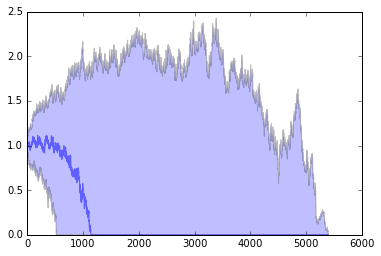

In [28]:
# Get the 10th, median, and 90th percentiles
bound_ts = bound_ts.loc[0:bound_ts.sum(axis=1).idxmin(), :]
plt.plot(bound_ts.index, bound_ts['median'], alpha=0.5)
plt.fill_between(bound_ts.index, bound_ts['lower'], bound_ts['upper'],
                 alpha=0.25)

### Distribution of values at a time

  Next, let's examine the distribution of resource levels at a fixed point in time.  In the example below, we are taking a cross-section at time $t=100$ to generate our histogram.  
  
   Note that we have ``NA`` values in our time series for steps "past" the end of a simulation.  In order to include simulations that  have already died out prior to $t=100$, we need to fill these ``NA`` values with zero.  We can do this with the [``pandas.DataFrame.fillna``](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) method.

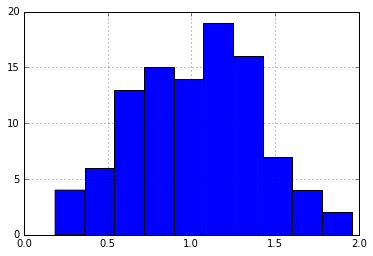

In [29]:
# Plot the distribution of resource values at time t=10
simulation_data.loc[100, :].fillna(0).hist()

### First hitting time distribution

  Lastly, we return to our original problem - what is the distribution of first hitting times?  In this case, this distribution tells us what our forest's expected lifetime might be based on modeled growth and consumption parameters.

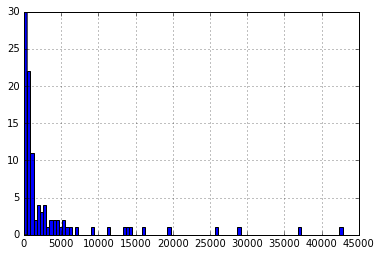

In [30]:
# Now, let's plot the distribution of first hitting times.
first_hitting_times = simulation_data.isnull().idxmax()
first_hitting_times.hist(bins=100)

## Simulation Performance

  While these simulations may have seemed quick compared to pen-and-paper addition, they were actually written to execute very slowly.  Let's walk through the examples below to learn about efficient sampling of many random numbers.

In [244]:
def run_simulation_fast(initial_resource=1, min_consumption=0.1, max_consumption=0.2, 
                   min_growth=0.1, max_growth=0.2, max_steps=100000, step_size=10000):
    """
    Simulate a resource under uniform arithmetic growth and consumption.
    """

    # Set model state variables
    current_resource = initial_resource
    resource_history = [current_resource]
    growth_history = []
    consumption_history = []

    # Continue running until the resource hits at or below zero
    while resource_history[-1] > 0:
        # Sample growth
        growth = numpy.random.uniform(min_growth, max_growth, step_size)

        # Sample consumption
        consumption = numpy.random.uniform(min_consumption, max_consumption, step_size)

        # Keep track of history
        resource_history.extend(resource_history[-1] + numpy.cumsum(growth) - numpy.cumsum(consumption))
        growth_history.extend(growth)
        consumption_history.extend(consumption)
        
        # Break at max steps or negative value
        if len(resource_history) > max_steps:
            break
    
    # Truncate "extra" negative samples and return
    if resource_history[-1] <= 0:
        # Get first negative index
        first_negative_index = numpy.min(numpy.where(numpy.sign(resource_history) < 1))
        return resource_history[0:first_negative_index]
    else:
        # If last value was > 0, then return full history.
        return resource_history
    


#### Simulations with low initial resource level

In [245]:
%%timeit -n 20
resource_history = run_simulation(initial_resource=1)

20 loops, best of 3: 12.4 ms per loop


In [246]:
%%timeit -n 20
resource_history = run_simulation_fast(initial_resource=1)

20 loops, best of 3: 7.33 ms per loop


#### Simulations with high initial resource level

In [247]:
%%timeit -n 20
resource_history = run_simulation(initial_resource=10)

20 loops, best of 3: 53.9 ms per loop


In [248]:
%%timeit -n 20
resource_history = run_simulation_fast(initial_resource=10)

20 loops, best of 3: 11.2 ms per loop


### What's the secret?

  In the first head-to-head comparison, our initial conditions resulted in forests that had comparatively lower expected lifetimes.  As a result, many of the simulations ended quickly, and the "batch" simulation of many steps resulted in "wasted" samples corresponding to dead forests that had to be thrown away.
  
  In the second head-to-head comparison, our initial conditions resulted in forests that had much longer expected lifetimes; many of the simulations will make it to the ``max_steps`` lifetime, at which time the simulation will halt.  As a result, we were able to __amortize__ the batch random number sampling over much larger simulation periods, and the fast method's performance was even better.

### Is there a faster way?

  In some cases, we can produce an even faster simulation method.   Let's examine the code below.

In [249]:
def run_simulation_fastest(initial_resource=1, min_consumption=0.1, max_consumption=0.2, 
                   min_growth=0.1, max_growth=0.2, max_steps=100000):
    """
    Simulate a resource under uniform arithmetic growth and consumption.
    """

    # Set model state variables
    resource_history = initial_resource + \
        numpy.cumsum(numpy.random.uniform(min_growth, max_growth, max_steps)) - \
        numpy.cumsum(numpy.random.uniform(min_consumption, max_consumption, max_steps))

    # Truncate "extra" negative samples and return
    if resource_history[-1] <= 0:
        # Get first negative index
        first_negative_index = numpy.min(numpy.where(numpy.sign(resource_history) < 1))
        return resource_history[0:first_negative_index]
    else:
        # If last value was > 0, then return full history.
        return resource_history  


#### Simulations with low initial resource level

In [250]:
%%timeit -n 20
resource_history = run_simulation(initial_resource=1)

The slowest run took 10.94 times longer than the fastest. This could mean that an intermediate result is being cached 
20 loops, best of 3: 1.74 ms per loop


In [251]:
%%timeit -n 20
resource_history = run_simulation_fast(initial_resource=1)

20 loops, best of 3: 6.54 ms per loop


In [252]:
%%timeit -n 20
resource_history = run_simulation_fastest(initial_resource=1)

20 loops, best of 3: 2.84 ms per loop


#### Simulations with high initial resource level

In [253]:
%%timeit -n 20
resource_history = run_simulation(initial_resource=10)

20 loops, best of 3: 55.7 ms per loop


In [254]:
%%timeit -n 20
resource_history = run_simulation_fast(initial_resource=10)

20 loops, best of 3: 13.4 ms per loop


In [255]:
%%timeit -n 20
resource_history = run_simulation_fastest(initial_resource=10)

20 loops, best of 3: 2.81 ms per loop


### What's the secret (this time)?

  If you're recall the section on __algorithmic complexity__ from [Chapter 3 of our Thinking Complexity book](http://www.greenteapress.com/compmod/html/thinkcomplexity004.html), you might notice that our "fastest" method appears to have a run time that doesn't vary with ``initial_resource``, whereas the "normal" and "fast" methods do.  In this case, we have an algorithm that is linear with ``max_steps`` but constant with respect to all other parameters.
  
  In general, we cannot always implement simulations in this fashion.  However, here are a few hints or restatements that you might be able to improve your simulation:
  
  * you sample many values from a random distribution whose parameters are __constant__ or __stationary__
  * you __do not__ have state-dependence in the sampling of your random variables
  * you can represent your step dynamics using vector or matrix operations, e.g., element-wise or cumulative arithmetic like addition or multiplication